In [14]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import matplotlib.pyplot as plt

In [15]:
# 1. 数据预处理
# 读取数据集
df = pd.read_csv('anonymous-msweb.data', skiprows=7, header=None)
# 清洗数据，处理缺失值等
# df = df.dropna()

C:\Users\w2306\AppData\Local\Temp\ipykernel_20600\652027670.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('anonymous-msweb.data', skiprows=7, header=None)


In [16]:
# 去除引号和逗号
df = df.replace({'"': '', ',': ''}, regex=True)

In [17]:
df.head
attribute_lines = df[df[0] == 'A']  # 属性行
other_lines = df[df[0] != 'A']  # 案例行
other_lines.head

<bound method NDFrame.head of         0      1      2    3    4
294     C  10001  10001  NaN  NaN
295     V   1000      1  NaN  NaN
296     V   1001      1  NaN  NaN
297     V   1002      1  NaN  NaN
298     C  10002  10002  NaN  NaN
...    ..    ...    ...  ...  ...
131654  V   1035      1  NaN  NaN
131655  V   1001      1  NaN  NaN
131656  V   1018      1  NaN  NaN
131657  C  42711  42711  NaN  NaN
131658  V   1008      1  NaN  NaN

[131365 rows x 5 columns]>

In [18]:
dic = {x[1]:x[3] for _,x in attribute_lines.iterrows()}
# print(dic)

In [19]:
cases = []
votes = []
vote = []
case_id = 0
for i, line in other_lines.iterrows():
    if line[0]=='C':
        if len(vote)!=0:
            votes.append(vote)
            cases.append(case_id)
        vote = []
        case_id = line[1]
    else:
        vote.append(dic[line[1]])
votes.append(vote)
cases.append(case_id)

In [20]:
print(len(cases))
print(len(votes))

32711
32711


In [21]:
print(len(attribute_lines))
# 清洗数据，处理缺失值等
attribute_lines = attribute_lines.dropna()
print(len(attribute_lines))

294
294


In [22]:
# 2. 数据探索性分析
# 分析最常被访问的页面

counter = Counter()
# 统计每个子列表中出现的值
for sublist in votes:
    counter.update(sublist)

# 获取出现频率最高的前十个值及其出现次数
most_common_values = counter.most_common(10)

# 打印结果
for value, count in most_common_values:
    print(f"值: {value}，出现次数: {count}")

值: Free Downloads，出现次数: 10836
值: Internet Explorer，出现次数: 9383
值: Microsoft.com Search，出现次数: 8463
值: isapi，出现次数: 5330
值: Products ，出现次数: 5108
值: Windows Family of OSs，出现次数: 4628
值: Support Desktop，出现次数: 4451
值: Internet Site Construction for Developers，出现次数: 3220
值: Knowledge Base，出现次数: 2968
值: Web Site Builder's Gallery，出现次数: 2123


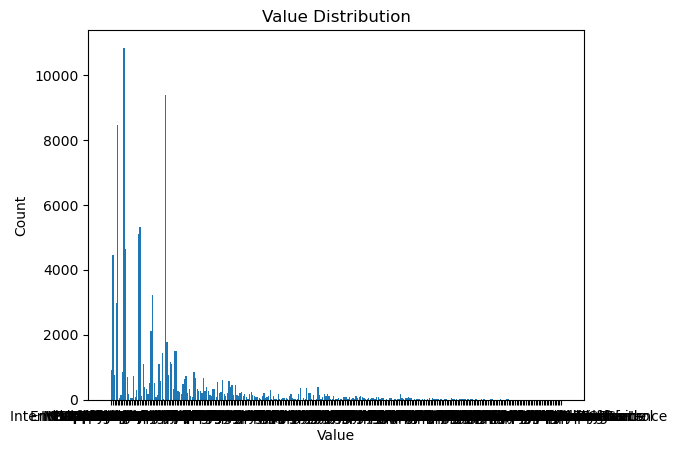

In [23]:
values = counter.keys()
counts = counter.values()

# 绘制柱状图
plt.bar(values, counts)

# 添加标题和轴标签
plt.title('Value Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

# 显示图形
plt.show()

                  0
count    284.000000
mean     347.373239
std     1173.084272
min        1.000000
25%       10.000000
50%       46.000000
75%      187.500000
max    10836.000000


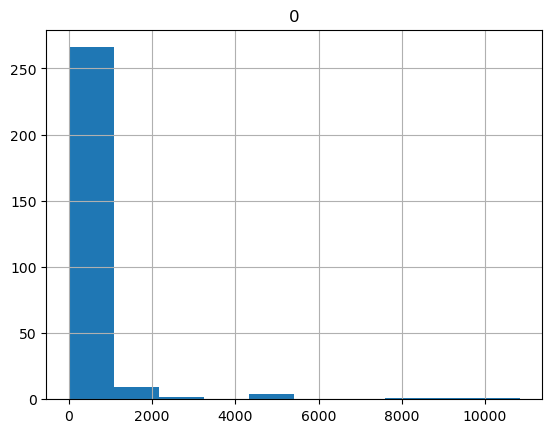

In [24]:
counts_df = pd.DataFrame(counts)
summary = counts_df.describe()

# 打印统计摘要信息
print(summary)
hist = counts_df.hist()

In [25]:
# 3. 关联规则挖掘
# 转换数据格式为TransactionEncoder所需的布尔矩阵形式
te = TransactionEncoder()
te_ary = te.fit_transform(votes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 使用Apriori算法计算频繁项集
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)

# 使用关联规则算法计算关联规则
association_results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)


In [26]:
print(association_results.head())

                    antecedents                                  consequents  \
0           (Internet Explorer)                             (Free Downloads)   
1              (Free Downloads)                          (Internet Explorer)   
2       (Windows Family of OSs)                             (Free Downloads)   
3                       (isapi)                             (Free Downloads)   
4  (Web Site Builder's Gallery)  (Internet Site Construction for Developers)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.286845            0.331265  0.160802    0.560588  1.692267   
1            0.331265            0.286845  0.160802    0.485419  1.692267   
2            0.141481            0.331265  0.077925    0.550778  1.662652   
3            0.162942            0.331265  0.073064    0.448405  1.353616   
4            0.064902            0.098438  0.035309    0.544041  5.526752   

   leverage  conviction  zhangs_metric  
0  0.065780    

In [27]:
# 4. 结果评估
# 打印关联规则的支持度、置信度、提升度和确信度
print("关联规则：")
association_results = association_results[['antecedents', 'consequents', 'support', 'confidence', 'lift','conviction']]
print(association_results)

关联规则：
                          antecedents  \
0                 (Internet Explorer)   
1                    (Free Downloads)   
2             (Windows Family of OSs)   
3                             (isapi)   
4        (Web Site Builder's Gallery)   
5                    (Knowledge Base)   
6                    (Knowledge Base)   
7                   (Support Desktop)   
8                    (Knowledge Base)   
9                   (Support Desktop)   
10                       (Windows 95)   
11                (Windows95 Support)   
12                (Windows95 Support)   
13     (Products , Internet Explorer)   
14        (Products , Free Downloads)   
15            (isapi, Free Downloads)   
16     (isapi, Windows Family of OSs)   
17            (isapi, Knowledge Base)   
18           (isapi, Support Desktop)   
19  (Knowledge Base, Support Desktop)   

                                    consequents   support  confidence  \
0                              (Free Downloads)  0.160802  

In [28]:
# 5. 结果分析与应用
# 根据分析结果提供导航结构优化建议等

针对以上实验结果，我们可以得到强相关规则：
1. Internet Explorer -> Free Downloads
2. Free Downloads -> Internet Explorer
3. Windows Family of OSs -> Free Downloads
4. isapi -> Free Downloads

可以看到Free Downloads的使用度很高，因此可以将其导航设置在更显眼更中心的位置；另外，Free Downloads与Internet Explorer、Support Desktop和Knowledge Base关联度较高，可以将这两个导航设置地更靠近。

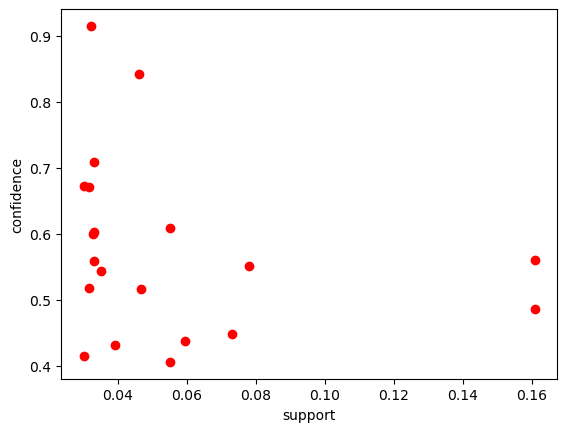

In [15]:
# 6.可视化展示
# 支持度与置信度关联关系展示
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(association_results.shape[0]):
    plt.scatter(association_results.support[i],association_results.confidence[i],c='r')

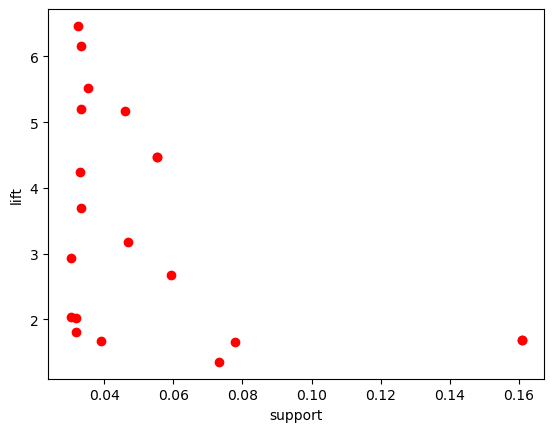

In [18]:
# 支持度与lift关联关系展示
plt.xlabel('support')
plt.ylabel('lift')
for i in range(association_results.shape[0]):
    plt.scatter(association_results.support[i],association_results.lift[i],c='r')